# Canadian Household Income Analysis

# Setup

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import polars as pl
import pandas as pd
import numpy as np
import plots
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


Define some constants to make key column names easier to reference.

In [ ]:
TOTAL_HOUSEHOLDS_COL = "HSBASHHD"
INSURANCE_COL = "HSEP001S"
PORTION_RET_INSUR_COL = "portion_retirement_insurance" # Our target column that we will calculate
INCOME_COL = "HSHNIAGG"
SEED = 42

Read the data.

In [ ]:
hs = pl.read_csv("./data/HouseholdSpend.csv")
ds = pl.read_csv("./data/DemoStats.csv")

# Check for initial null or NaN values
# Assert no NaNs in a DataFrame with float columns
assert not hs.drop_nans().shape[0] < hs.shape[0], "Spending DataFrame contains NaN values"
assert not ds.drop_nans().shape[0] < ds.shape[0], "Demographics DataFrame contains NaN values"
assert not hs.drop_nulls().shape[0] < hs.shape[0], "Spending DataFrame contains null values"
assert not ds.drop_nulls().shape[0] < ds.shape[0], "Demographics DataFrame contains null values"

display(hs.describe())
display(ds.describe())

Drop the zip code and geography level columns - these are just IDs that won't help our model.

In [ ]:
hs.drop_in_place("CODE")
hs.drop_in_place("GEO")
ds.drop_in_place("GEO")
ds.drop_in_place("CODE")


## Feature Engineering

Currently all the household spending variables represent total spending for entire neighbourhood; we will convert them to average per household spending which is probably a better predictor of per household insurance contribution. We don't want to confuse the model with some neighbourhoods having dramatically higher spending only because of high population.

Then we will construct our target variable, the portion of income a household spends on insurance and retirement savings.

In [ ]:
total_households = hs.select(TOTAL_HOUSEHOLDS_COL)
hs.drop_in_place(TOTAL_HOUSEHOLDS_COL)
hs = hs.with_columns(
    pl.all() / total_households[TOTAL_HOUSEHOLDS_COL]
)

# Construct our target variable: portion of income spent on insurance and retirement
hs = hs.with_columns(
    (hs[INSURANCE_COL] / hs[INCOME_COL]).alias(PORTION_RET_INSUR_COL)
)

hs = hs.fill_nan(0) # replace NaNs resulting from zip codes with no households; we will remove these later
hs.describe()

## Feature Selection

Let's remove some redundant features. We'll first drop features highly correlated with our target variable. Then, we'll read in the metadata file for the dataset, which is structured like a pre-order depth first search tree traversal. We'll use this metadata to identify and delete the non-"leaf node" features that don't give us any new info. For example, "Total Population" is redundant when we have "Total Male Population", "Total Female Population" and "Total Other Population". 

In [ ]:
# drop columns used to calculate target or highly correlated with the target (related to income or insurance spend)
columns_to_drop = [INCOME_COL, "HSAGDISPIN", "HSAGDISCIN", INSURANCE_COL]
for col in columns_to_drop:
    hs.drop_in_place(col)


In [ ]:
def get_columns_to_drop(metadata_file):
    # Read the metadata file
    df = pl.read_csv(metadata_file)
    
    #Initialize lists for variables to drop
    non_leaf_variables = []
    summary_variables = []
    
    # process rows in order to identify non-leaf nodes
    for i in range(len(df)):
        var = df['Variable'][i]
        hier_level = df['Hierarchy Level'][i]
        

        # Check if this is a summary variable (ends with AVG or MED)
        if var.endswith('AVG') or var.endswith('MED'):
            summary_variables.append(var)
            continue
        
        # Check if the next row exists and is a direct child
        if i < len(df) - 1 and df['Hierarchy Level'][i+1] == hier_level + 1:
            # This is a parent node (has at least one child)
            non_leaf_variables.append(var)
    
    #  Combine all var to drop
    columns_to_drop = list(set(non_leaf_variables +  summary_variables))
    
    return columns_to_drop


ds_columns_to_drop = get_columns_to_drop("data\DemoStats 2024 - Metadata.csv")
hs_columns_to_drop = get_columns_to_drop("data\HouseholdSpend 2024 - Metadata.csv")

# set aside insurance and retirement - this is our target variable

dropped_hs_columns = []
for col in hs_columns_to_drop:
    if col in hs.columns:
        hs.drop_in_place(col)
        dropped_hs_columns.append(col)
print(f"Dropped columns from hs: {', '.join(dropped_hs_columns)}")

dropped_ds_columns = []
for col in ds_columns_to_drop:
    if col in ds.columns:
        ds.drop_in_place(col)
        dropped_ds_columns.append(col)
print(f"Dropped columns from ds: {', '.join(dropped_ds_columns)}")


display(hs.describe())
display(ds.describe())

## Missing Values and Imputation

Let's join the two datasets together so we have a single feature matrix.

In [ ]:
data = pl.concat([hs, ds], how="horizontal")
display(data.describe())

Drop rows where total population is 0 or > 5% of the values are negative/invalid. These represent empty postal codes that will only add noise to our data.
Also drop columns where all values are zero or > 5% of the values are negative/invalid.

In [ ]:
# Drop rows where total population is 0 or has too many invalid values
invalid_row_threshold = 0.05  # 5% threshold

# filter rows where > 5% of values are invalid
data = data.filter(
    ~(pl.sum_horizontal(pl.all().lt(0)) / pl.sum_horizontal(pl.all().is_not_null()) > invalid_row_threshold)
)

# filter out rows where total population is 0
data = data.filter(~pl.all_horizontal(pl.all().eq(0)))

# filter out columns where > 5% of values are invalid
numeric_cols = [s.name for s in data]
cols_to_drop = [col for col in numeric_cols if (data[col] < 0).sum() / hs.height > invalid_row_threshold]
data.drop(cols_to_drop)

# drop all zero columns
data.drop(
    [col for col in hs.columns if (data[col] == 0).all()]
)
display(data.describe())

Some of the spending variables have negative values which is obviously not valid. We will impute them with the median. We can see from the display() output that some columns' max spending values are in the 9-figure range. This is way outside a typical neighbourhood's spend in any category. We will cap extreme outliers by truncating all values above 3 * IQR for all the columns in the spending dataframe.

Finally, we will standardize the data using z-scores.

In [ ]:
class NegativeValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.medians = None
        
    def fit(self, X, y=None):
        # X can be a DataFrame or np  array
        if isinstance(X, pd.DataFrame):
            self.medians = {}
            for col in X.columns:
                # Calculate median of non-negative values
                non_negative_values = X.loc[X[col] >= 0, col]
                self.medians[col] = non_negative_values.median() if len(non_negative_values) > 0 else 0
        else:
            self.medians = []
            for i in range(X.shape[1]):
                non_negative_values = X[:, i][X[:, i] >= 0]
                self.medians.append(np.median(non_negative_values) if len(non_negative_values) > 0 else 0)
                
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        if isinstance(X_copy, pd.DataFrame):
            for col in X_copy.columns:
                mask = X_copy[col] < 0
                X_copy.loc[mask, col] = self.medians[col]
        else:  # numpy array
            for i in range(X_copy.shape[1]):
                mask = X_copy[:, i] < 0
                X_copy[mask, i] = self.medians[i]
                

        return X_copy

class IQRClippingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier= 3):
        self.multiplier = multiplier
        self.upper_bounds_ = {  }   


    def fit(self, X, y=None):
        df = pl.DataFrame(X)
          
        for col in df.columns:
            q1 = df[col].quantile(.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            self.upper_bounds_[col] = q3 + self.multiplier * iqr
        
        return self
    
    def transform(self, X):
        df = pl.DataFrame(X)    
         
        for col in df.columns:  
            if col in self.upper_bounds_:
                upper_bound = self.upper_bounds_[ col]
                df = df.with_columns(
                     pl.when(pl.col(col) > upper_bound)
                    .then(upper_bound)
                    .otherwise(pl.col(col)) 
                    .alias(col) )
        
        return  df.to_numpy()

In [ ]:
y = data[PORTION_RET_INSUR_COL]
X = data.drop(PORTION_RET_INSUR_COL)

display(X)
display(y)

# Impute negative values and clip outliers
# Construct the pipeline
preprocess = Pipeline([
    ('impute_negatives', NegativeValueImputer()),
    ('clip_outliers', IQRClippingTransformer(multiplier=3)),
    ('standardize', StandardScaler())
])

# Apply the pipeline to the data
# X_processed = preprocess.fit_transform(X.to_pandas())

# Convert back to Polars DataFrame
# X_processed = pl.DataFrame(X_processed)

# set columns
# X_processed.columns = X.columns

# display(X_processed.describe())

# k-Means Clustering

## Preprocessing
We will undersample the feature matrix to improve clustering runtime. Then we'll preprocess the entire dataset.

In [ ]:
# Undersample to reduce training time
X_proc_kmeans_sampled = X.sample(fraction=0.1, seed=SEED) 
X_kmeans_sampled = X.sample(fraction=0.1, seed=SEED) 

In [ ]:
# Apply the pipeline to the data
X_proc_kmeans_sampled = preprocess.fit_transform(X_proc_kmeans_sampled.to_pandas())

# Convert back to Polars DataFrame
X_proc_kmeans_sampled = pl.DataFrame(X_proc_kmeans_sampled)

# set columns
X_proc_kmeans_sampled.columns = X.columns

display(X_proc_kmeans_sampled.describe())

## Elbow Method
Let's try to use the elbow method to identify the optimal number of clusters.

In [ ]:
kmean = KMeans(random_state=SEED, n_init=10)
vis = KElbowVisualizer(kmean, k=(2, 12))
vis.fit(X_proc_kmeans_sampled.to_pandas())  
optimal_k = vis.elbow_value_
final_kmeans = KMeans(n_clusters=optimal_k, random_state=SEED, n_init=10)
elb_cluster_labels = final_kmeans.fit_predict(X_proc_kmeans_sampled.to_pandas())
vis.show()

In [ ]:
elb_clust_res = X_kmeans_sampled.group_by(pl.Series(elb_cluster_labels)).mean()
elb_clust_res


The elbow lies at k=6, suggesting 6 clusters is ideal. The clusters are difficult to interpret due to the high dimensionality. Generally, the ratio between the average value of each cluster for each column is the same, signalling that overall spending explains the most variance between the clusters. In other words, rich people (cluster 4) spend more on just about everything compared to the poorest (cluster 0).

In [ ]:
sil_models = []
labels = []
for clusts in range(2, 12):
    sil_models.append(KMeans(n_clusters=clusts, random_state=SEED, n_init=10))
    labels.append(f'KMeans Clustering, Clusters = {clusts}')
plots.plot_silhouettes(sil_models, labels, X_proc_kmeans_sampled)

In [ ]:
sil_cluster_labels = sil_models[0].fit_predict(X_proc_kmeans_sampled.to_pandas())
sil_clust_res = X_kmeans_sampled.group_by(pl.Series(sil_cluster_labels)).mean()
sil_clust_res

Broadly, the silhouette plot agrees with the elbow method in that choosing fewer clusters is better, with k=2 (the best value identified by the cluster method) having a better average silhouette score (0.38) compared to higher k values. However, no number of clusters produces a particularly good clustering. k=2 produces two imbalanced clusters with the cluster labelled 0 having significantly fewer points and worse average silhouette score. Higher k values are even worse, with most points  closer to other clusters than their own. This could stem from multiple factors related to the dataset. In high-dimensional spaces, distances tend to become less meaningful due to the curse of dimensionality, making it difficult for clustering algorithms to identify well-separated groups. k-means in particular assumes convex clusters and may struggle with complex structures. Or perhaps the Euclidean distance used is not suitable for this dataset, as is often the case when there are many features. To improve clustering performance, techniques such as PCA for dimensionality reduction, alternative clustering methods (such as spectral clustering methods), and different distance metrics (e.g., cosine similarity) could be considered.

Similar to the k = 6 clustering, the k = 2 clustering seems to have simply divided the dataset into a slightly higher income group that spends a bit more on everything (cluster 0) vs. a slightly lower income group (cluster 1).

# Regularized Linear Regression Model

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\kevin\AppData\Local\Temp\ipykernel_9136\2169555329.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_copy.loc[mask, col] = self.medians[col]
C:\Users\kevin\AppData\Local\Temp\ipykernel_9136\2169555329.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_copy.loc[mask, col] = self.medians[col]
C:\Users\kevin\AppData\Local\Temp\ipykernel_9136\2169555329.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_copy.loc[mask, col] = self.medians[col]
C

Best parameters found:  {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.5}


C:\Users\kevin\AppData\Local\Temp\ipykernel_9136\2169555329.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_copy.loc[mask, col] = self.medians[col]


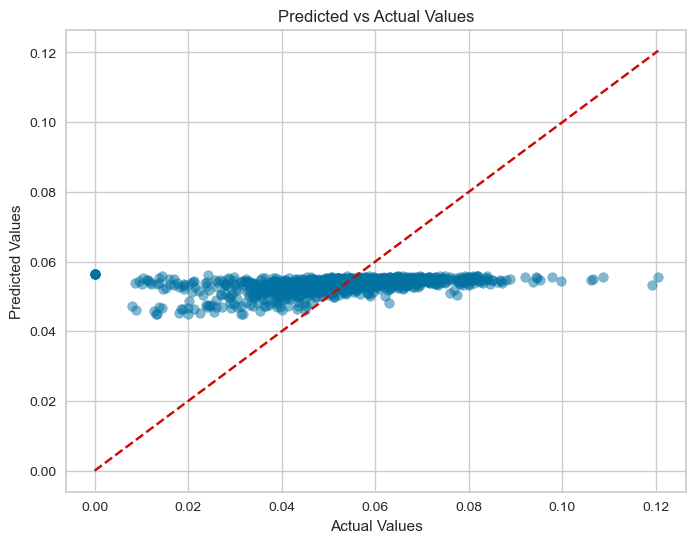

In [ ]:
lin_mod_param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
}

full_pipeline_lin = Pipeline([
    ('preprocess', preprocess),
    ('elasticnet', ElasticNet(max_iter=10000, random_state=SEED))
])

# sample for quick test
X = X.sample(fraction=0.1, seed=SEED)
y = y.sample(fraction=0.1, seed=SEED)

X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

lin_mod_grid_search = GridSearchCV(
    full_pipeline_lin,
    param_grid=lin_mod_param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    verbose=1
)

lin_mod_grid_search.fit(X_train_lin.to_pandas(), y_train_lin.to_pandas())
print("Best parameters found: ", lin_mod_grid_search.best_params_)
best_model = lin_mod_grid_search.best_estimator_
y_pred_lin = best_model.predict(X_test_lin.to_pandas())

# Plot scatterplot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_lin, y_pred_lin, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Proportion of Income Spent on Insurance and Retirement')
plt.plot([y_test_lin.min(), y_test_lin.max()], [y_test_lin.min(), y_test_lin.max()], 'r--')

In [ ]:
def bootstrap_CI_regression(y_test, y_pred, n_bs=1000, alpha= 0.05):
    """Calculate bootstrap confidence intervals for MSE and R2 scores in regression
    
    Args:
        y_test (array-like): True target values
        y_pred (array-like): Predicted target values
        n_bs (int, optional): Number of bootstrap iterations.  Defaults to 1000.
        alpha (float, optional): Significance level for confidence interval. Defaults to 0.05.
        
    Returns:
        tuple: Two tuples containing:
    - (mse_ci_lower,  mse_ci_upper): Lower and upper bounds ofMSE confidence interval
    - (r2_ci_lower, r2_ci_upper): Lower and upper bounds of R sq confidence interval
    """
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test,  y_pred)
    
    bs_mse =  np.zeros(n_bs)
    bs_r2 =  np.zeros(n_bs)
    
    for i in range(n_bs):
        rand_idx = np.random.choice(len(y_test), len(y_test), replace=True)
        bs_mse[i] = mean_squared_error(y_test[rand_idx], y_pred[rand_idx])
        bs_r2[i] = r2_score(y_test[rand_idx], y_pred[rand_idx])
    
    bs_mse_spread = bs_mse -  mse
    bs_r2_spread = bs_r2 - r2
     
     
    mse_ci_lower = mse - np.percentile(bs_mse_spread, 100 * (1 - alpha / 2))
    mse_ci_upper = mse - np.percentile(bs_mse_spread, 100 * (alpha / 2))
    r2_ci_lower = r2 - np.percentile(bs_r2_spread, 100 * (1 - alpha / 2))
    r2_ci_upper = r2 - np.percentile(bs_r2_spread, 100 * (alpha / 2))
    
    return (mse_ci_lower, mse_ci_upper), (r2_ci_lower, r2_ci_upper)

mse_ci, r2_ci = bootstrap_CI_regression(y_test_lin.to_pandas(), y_pred_lin)
print(f"Mean Squared Error: {mean_squared_error(y_test_lin.to_pandas(), y_pred_lin):.4}")
print(f"R-squared: {r2_score(y_test_lin.to_pandas(), y_pred_lin):.4}")
print(f"Bootstrap 95% CI for MSE: ({mse_ci[0]:.4}, {mse_ci[1]:.4})")

print(f"Bootstrap 95% for Rsquared: ({r2_ci[0]:.4}, {r2_ci[1]:.4})")

Mean Squared Error: 0.0002312
R-squared: 0.1
Bootstrap 95% CI for MSE: (0.0002051, 0.0002571)
Bootstrap 95% for R-squared: (0.08124, 0.1195)


In [ ]:
# Print 5 most impactful features and their ranking
feature_importances = best_model.named_steps['elasticnet'].coef_
feature_names = X.columns
sorted_indices = np.argsort(np.abs(feature_importances))[::-1][:5]
print("Top 5 most impactful features and their coefficients:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.9f}")

Top 5 most impactful features:
HSMG001S: -0.001254251
HSHO002: -0.000618779
HSHC009: -0.000476021
HSHC003: -0.000049822
ECYHTA2529: 0.000000000
